In [1]:
from matplotlib import pyplot as plt
from matplotlib import style
from tabulate import tabulate
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer

In [3]:
style.use(style='seaborn-whitegrid')

---

Load the data

In [4]:
nrows = 50000
data = pd.read_csv(filepath_or_buffer='preprocessed_data.csv', nrows=nrows)

In [5]:
display(data.columns)

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [6]:
y = data['project_is_approved'].values
X = data.drop(labels=['project_is_approved'], axis=1)

In [7]:
print("The shape of X: {}".format(X.shape))
print("The shape of y: {}".format(y.shape))

The shape of X: (50000, 8)
The shape of y: (50000,)


Reference on numerical and categorical columns: https://stackoverflow.com/a/62273776/7579443

In [8]:
numcols = X.select_dtypes('number').columns
catcols = X.select_dtypes('object').columns
numcols= list(set(numcols))
catcols= list(set(catcols))
print(numcols)
print(catcols)

['price', 'teacher_number_of_previously_posted_projects']
['project_grade_category', 'teacher_prefix', 'clean_categories', 'essay', 'school_state', 'clean_subcategories']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33500, 8) (33500,)
(16500, 8) (16500,)


---

Encode categorical column

In [11]:
def encode_categorical_column(train_data, test_data, column, tfidf_flag=False):
    """
    This function encodes the categorical column.
    """
    if column == 'essay':
        if tfidf_flag:
            encoded_vect = TfidfVectorizer(min_df=10, ngram_range=(1, 4), max_features=5000)
        else:
            encoded_vect = CountVectorizer(min_df=10, ngram_range=(1, 4), max_features=5000)
    else:
        if tfidf_flag:
            encoded_vect = TfidfVectorizer()
        else:
            encoded_vect = CountVectorizer()
    encoded_vect.fit(raw_documents=train_data[column].values)
    train_vect = encoded_vect.transform(raw_documents=train_data[column].values)
    test_vect = encoded_vect.transform(raw_documents=test_data[column].values)
    return (train_vect, test_vect)

---

Normalize numerical column

In [12]:
def normalize_numerical_column(train_data, test_data, column):
    """
    This function normalizes the numerical column.
    """
    norm = Normalizer()
    try:
        norm.fit(X=train_data[column].values.reshape(1, 1))
    except:
        pass
    train_norm = norm.transform(X=train_data[column].values.reshape(1, -1)).reshape(-1, 1)
    test_norm = norm.transform(X=test_data[column].values.reshape(1, -1)).reshape(-1, 1)
    return (train_norm, test_norm)

---

Combine all columns

In [13]:
def combine_all_columns(train_data, test_data, catcols, numcols, tfidf_flag):
    """
    This function combines all categorical and numerical features.
    """
    train_all_columns = list()
    test_all_columns = list()
    print("Combining categorical features.")
    for catcol in tqdm(catcols):
        train_column_bow, test_colum_bow = encode_categorical_column(train_data=train_data,
                                                                     test_data=test_data,
                                                                     column=catcol,
                                                                     tfidf_flag=tfidf_flag)
        train_all_columns.append(train_column_bow)
        test_all_columns.append(test_colum_bow)
    print("Combining numerical features.")
    for numcol in tqdm(numcols):
        train_column_norm, test_column_norm = normalize_numerical_column(train_data=train_data,
                                                                         test_data=test_data,
                                                                         column=numcol)
        train_all_columns.append(train_column_norm)
        test_all_columns.append(test_column_norm)
    print("Preparing model-ready data.")
    train_combined_data = hstack(blocks=train_all_columns).tocsr()
    test_combined_data = hstack(blocks=test_all_columns).tocsr()
    print("Done!")
    return train_combined_data, test_combined_data

---

Batch-wise prediction

In [14]:
def batch_predict_proba(clf, data, batch_size=1000):
    """
    This function takes the input in batches and predicts the probability scores for positive class.
    """
    y_pred_proba = list()
    tr_loop = (data.shape[0] - (data.shape[0] % batch_size))
    for i in range(0, tr_loop, batch_size):
        y_pred_proba.extend(clf.predict_proba(X=data[i:i+batch_size])[:, 1])
    if data.shape[0] % batch_size != 0:
        y_pred_proba.extend(clf.predict_proba(X=data[tr_loop:])[:, 1])
    return y_pred_proba

---

Draw the AUC plot

In [15]:
def draw_auc(best_alpha, X_train_data, X_test_data, y_train, y_test, plot_it=True):
    """
    Draws AUC plot.
    """
    clf = MultinomialNB(alpha=best_alpha)
    clf.fit(X=X_train_data, y=y_train)
    
    y_train_pred_proba = batch_predict_proba(clf=clf, data=X_train_data)
    y_test_pred_proba = batch_predict_proba(clf=clf, data=X_test_data)
    
    train_fpr, train_tpr, train_taus = roc_curve(y_true=y_train, y_score=y_train_pred_proba)
    test_fpr, test_tpr, test_taus = roc_curve(y_true=y_test, y_score=y_test_pred_proba)
    
    tr_auc = round(auc(x=train_fpr, y=train_tpr), 3)
    te_auc = round(auc(x=test_fpr, y=test_tpr), 3)
    
    if plot_it:
        plt.figure(figsize=(12, 6))

        plt.plot(train_fpr, train_tpr, label='Train AUC = {}'.format(tr_auc))
        plt.plot(test_fpr, test_tpr, label='Test AUC = {}'.format(te_auc))

        plt.title(label='AUC')
        plt.xlabel(xlabel='FPR')
        plt.ylabel(ylabel='TPR')
        plt.legend()
        plt.show()
    else:
        return (y_train_pred_proba, y_test_pred_proba, train_taus, train_fpr, train_tpr, tr_auc, te_auc, clf)

---

Best tau and confusion matrix

In [16]:
def find_best_tau(taus, fpr, tpr):
    """
    The (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high.
    """
    tau = round(taus[np.argmax(a=tpr*(1-fpr))], 3)
    tpr_1_fpr = round(max(tpr*(1-fpr)), 3)
    print("The maximum value of tpr*(1-fpr) is {} for tau {}.".format(tpr_1_fpr, tau))
    return tau

def predict_using_best_tau(proba, best_tau):
    """
    This function predicts using best tau.
    """
    predictions = list()
    for i in proba:
        if i >= best_tau:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

---

Set 1

In [17]:
X_train_data_bow, X_test_data_bow = combine_all_columns(train_data=X_train,
                                                        test_data=X_test,
                                                        catcols=catcols,
                                                        numcols=numcols,
                                                        tfidf_flag=False)

Combining categorical features.


100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.30s/it]


Combining numerical features.


100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1724.99it/s]


Preparing model-ready data.
Done!


In [18]:
print(X_train_data_bow.shape, y_train.shape)
print(X_test_data_bow.shape, y_test.shape)

(33500, 5101) (33500,)
(16500, 5101) (16500,)


`MultinomialNB` and `GridSearchCV` on Set 1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.018149,0.002066,0.007820,0.000358,0.00001,{'alpha': 1e-05},0.689688,0.679008,0.687380,0.685359,0.004588,8,0.750035,0.759915,0.752450,0.754133,0.004205
2,0.016372,0.000079,0.007494,0.000020,0.0001,{'alpha': 0.0001},0.689759,0.679008,0.687610,0.685459,0.004645,7,0.750031,0.759914,0.752450,0.754132,0.004207
1,0.016856,0.000809,0.007668,0.000264,0.0005,{'alpha': 0.0005},0.689813,0.679008,0.687777,0.685533,0.004688,5,0.750026,0.759914,0.752450,0.754130,0.004208
4,0.016358,0.000064,0.007536,0.000029,0.001,{'alpha': 0.001},0.689832,0.679008,0.687815,0.685552,0.004700,4,0.750024,0.759913,0.752448,0.754128,0.004208
3,0.016436,0.000271,0.007518,0.000020,0.005,{'alpha': 0.005},0.689875,0.679002,0.687840,0.685573,0.004720,2,0.750013,0.759907,0.752442,0.754121,0.004210
6,0.016352,0.000160,0.007554,0.000045,0.01,{'alpha': 0.01},0.689891,0.678999,0.687836,0.685575,0.004725,1,0.750002,0.759899,0.752433,0.754111,0.004211
5,0.016296,0.000078,0.007594,0.000117,0.05,{'alpha': 0.05},0.689905,0.678971,0.687809,0.685562,0.004738,3,0.749941,0.759835,0.752369,0.754048,0.004210
7,0.016478,0.000110,0.007500,0.000015,0.1,{'alpha': 0.1},0.689892,0.678930,0.687760,0.685527,0.004746,6,0.749872,0.759759,0.752296,0.753975,0.004208
8,0.016785,0.000654,0.007699,0.000124,0.5,{'alpha': 0.5},0.689671,0.678620,0.687424,0.685238,0.004769,9,0.749339,0.759139,0.751741,0.753406,0.004171
9,0.016329,0.000067,0.007619,0.000023,1,{'alpha': 1},0.689343,0.678228,0.686982,0.684851,0.004781,10,0.748654,0.758375,0.751081,0.752703,0.004131


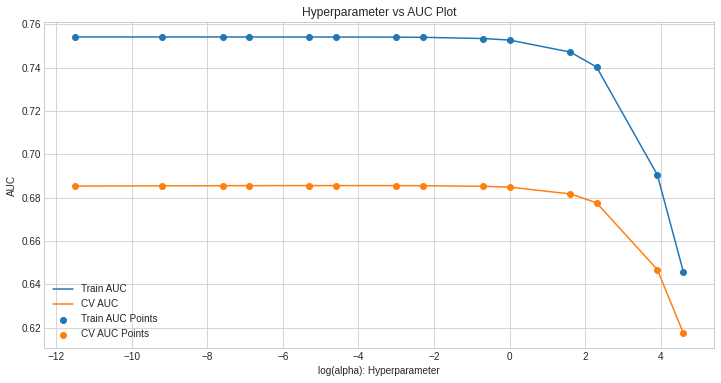

In [19]:
parameters = {'alpha': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]}

nb_mul_clf = MultinomialNB(class_prior=[0.5, 0.5])

grid_cv_clf = GridSearchCV(estimator=nb_mul_clf, param_grid=parameters, cv=3, scoring='roc_auc', return_train_score=True)
grid_cv_clf.fit(X=X_train_data_bow, y=y_train)

results = pd.DataFrame.from_dict(data=grid_cv_clf.cv_results_).sort_values(['param_alpha'])
display(results)

train_auc = results['mean_train_score'].values
train_auc_std = results['std_train_score'].values
cv_auc = results['mean_test_score'].values
cv_auc_std = results['std_test_score'].values
alphas = results['param_alpha'].values.astype(float)
log_alphas = np.log(alphas)

plt.figure(figsize=(12, 6))

plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(x=log_alphas, y=train_auc, label='Train AUC Points')
plt.scatter(x=log_alphas, y=cv_auc, label='CV AUC Points')

plt.title(label='Hyperparameter vs AUC Plot')
plt.xlabel(xlabel='log(alpha): Hyperparameter')
plt.ylabel(ylabel='AUC')
plt.legend()
plt.show()

Best aplha on Set 1

In [20]:
best_params_1 = grid_cv_clf.best_estimator_.get_params()
print(best_params_1)
best_alpha_1 = best_params_1['alpha']
print(best_alpha_1)

{'alpha': 0.01, 'class_prior': [0.5, 0.5], 'fit_prior': True}
0.01


AUC plot on Set 1

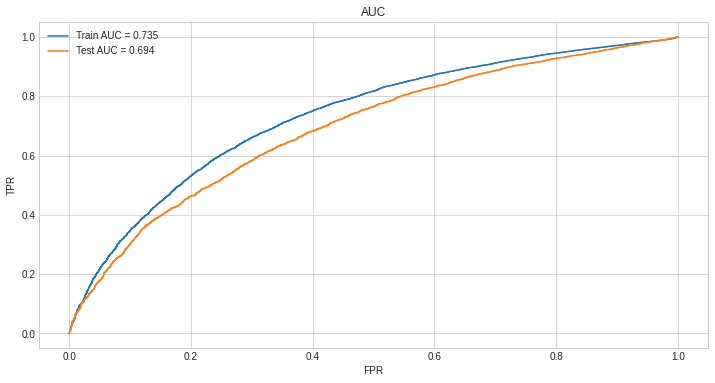

In [21]:
draw_auc(best_alpha=best_alpha_1,
         X_train_data=X_train_data_bow,
         X_test_data=X_test_data_bow,
         y_train=y_train,
         y_test=y_test)

Best tau and confusion matrix on Set 1

In [22]:
(y_train_pred_proba,
 y_test_pred_proba,
 train_taus,
 train_fpr,
 train_tpr,
 tr_auc_1,
 te_auc_1,
 nb_clf_1) = draw_auc(best_alpha=best_alpha_1,
                      X_train_data=X_train_data_bow,
                      X_test_data=X_test_data_bow,
                      y_train=y_train,
                      y_test=y_test,
                      plot_it=False)

best_tau = find_best_tau(taus=train_taus, fpr=train_fpr, tpr=train_tpr)
print("\nTrain Confusion Matrix")
print(confusion_matrix(y_true=y_train,
                       y_pred=predict_using_best_tau(proba=y_train_pred_proba,
                                                     best_tau=best_tau)))
print("\nTest Confusion Matrix")
print(confusion_matrix(y_true=y_test,
                       y_pred=predict_using_best_tau(proba=y_test_pred_proba,
                                                     best_tau=best_tau)))

The maximum value of tpr*(1-fpr) is 0.463 for tau 0.837.

Train Confusion Matrix
[[ 3683  1682]
 [ 9147 18988]]

Test Confusion Matrix
[[1646  996]
 [4697 9161]]


---

Set 2

In [23]:
X_train_data_tfidf, X_test_data_tfidf = combine_all_columns(train_data=X_train,
                                                            test_data=X_test,
                                                            catcols=catcols,
                                                            numcols=numcols,
                                                            tfidf_flag=True)

Combining categorical features.


100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:55<00:00,  9.24s/it]


Combining numerical features.


100%|███████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1170.94it/s]


Preparing model-ready data.
Done!


In [24]:
print(X_train_data_tfidf.shape, y_train.shape)
print(X_test_data_tfidf.shape, y_test.shape)

(33500, 5101) (33500,)
(16500, 5101) (16500,)


`MultinomialNB` and `GridSearchCV` on Set 2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.018393,0.001641,0.007891,0.000205,0.00001,{'alpha': 1e-05},0.666289,0.658293,0.674963,0.666515,0.006807,1,0.739608,0.746749,0.741411,0.742589,0.003032
2,0.017883,0.000751,0.008664,0.000262,0.0001,{'alpha': 0.0001},0.666288,0.658292,0.674963,0.666514,0.006808,2,0.739606,0.746747,0.741409,0.742588,0.003032
1,0.016539,0.000517,0.007683,0.000042,0.0005,{'alpha': 0.0005},0.666283,0.658286,0.674958,0.666509,0.006808,3,0.739599,0.746739,0.741403,0.742580,0.003031
4,0.017902,0.000032,0.008379,0.000025,0.001,{'alpha': 0.001},0.666277,0.658283,0.674955,0.666505,0.006808,4,0.739591,0.746726,0.741393,0.742570,0.003030
3,0.018382,0.000150,0.008767,0.000179,0.005,{'alpha': 0.005},0.666218,0.658232,0.674916,0.666455,0.006813,5,0.739520,0.746640,0.741319,0.742493,0.003023
6,0.015943,0.000025,0.007740,0.000047,0.01,{'alpha': 0.01},0.666159,0.658169,0.674870,0.666400,0.006820,6,0.739429,0.746529,0.741226,0.742395,0.003014
5,0.017173,0.000783,0.008172,0.000421,0.05,{'alpha': 0.05},0.665658,0.657621,0.674446,0.665908,0.006871,7,0.738702,0.745660,0.740495,0.741619,0.002950
7,0.016147,0.000357,0.007665,0.000061,0.1,{'alpha': 0.1},0.665104,0.656910,0.674172,0.665396,0.007050,8,0.737782,0.744584,0.739587,0.740651,0.002877
8,0.016485,0.000606,0.008445,0.000872,0.5,{'alpha': 0.5},0.660124,0.651788,0.669926,0.660613,0.007413,9,0.730621,0.736386,0.732342,0.733117,0.002417
9,0.016071,0.000117,0.007731,0.000154,1,{'alpha': 1},0.653659,0.645864,0.663898,0.654474,0.007385,10,0.721965,0.726997,0.723587,0.724183,0.002097


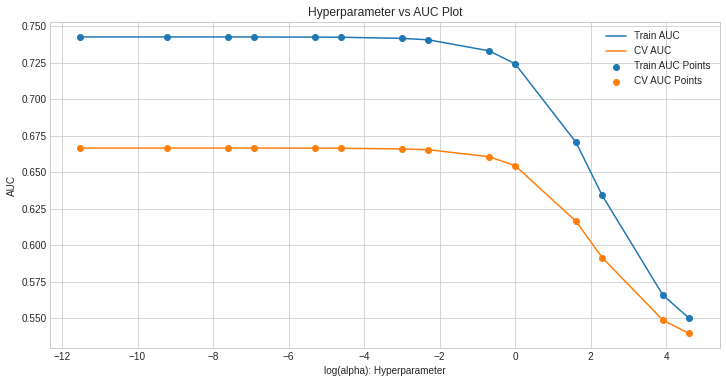

In [25]:
parameters = {'alpha': [0.00001, 0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]}

nb_mul_clf = MultinomialNB(class_prior=[0.5, 0.5])

grid_cv_clf = GridSearchCV(estimator=nb_mul_clf, param_grid=parameters, cv=3, scoring='roc_auc', return_train_score=True)
grid_cv_clf.fit(X=X_train_data_tfidf, y=y_train)

results = pd.DataFrame.from_dict(data=grid_cv_clf.cv_results_).sort_values(['param_alpha'])
display(results)

train_auc = results['mean_train_score'].values
train_auc_std = results['std_train_score'].values
cv_auc = results['mean_test_score'].values
cv_auc_std = results['std_test_score'].values
alphas = results['param_alpha'].values.astype(float)
log_alphas = np.log(alphas)

plt.figure(figsize=(12, 6))

plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(x=log_alphas, y=train_auc, label='Train AUC Points')
plt.scatter(x=log_alphas, y=cv_auc, label='CV AUC Points')

plt.title(label='Hyperparameter vs AUC Plot')
plt.xlabel(xlabel='log(alpha): Hyperparameter')
plt.ylabel(ylabel='AUC')
plt.legend()
plt.show()

Best aplha on Set 2

In [26]:
best_params_2 = grid_cv_clf.best_estimator_.get_params()
print(best_params_2)
best_alpha_2 = best_params_2['alpha']
print(best_alpha_2)

{'alpha': 1e-05, 'class_prior': [0.5, 0.5], 'fit_prior': True}
1e-05


AUC plot on Set 2

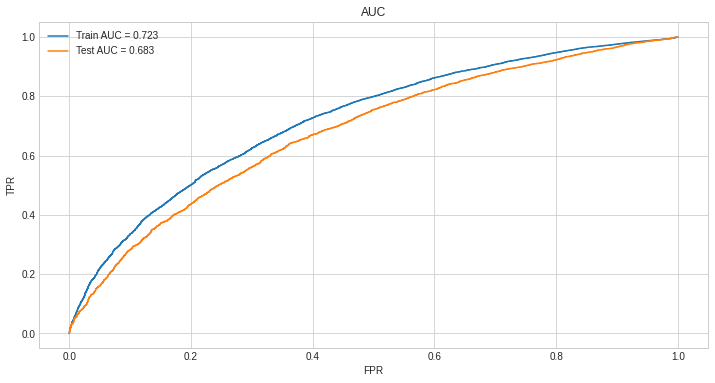

In [27]:
draw_auc(best_alpha=best_alpha_2,
         X_train_data=X_train_data_tfidf,
         X_test_data=X_test_data_tfidf,
         y_train=y_train,
         y_test=y_test)

Best tau and confusion matrix on Set 2

In [28]:
(y_train_pred_proba,
 y_test_pred_proba,
 train_taus,
 train_fpr,
 train_tpr,
 tr_auc_2,
 te_auc_2,
 nb_clf_2) = draw_auc(best_alpha=best_alpha_2,
                      X_train_data=X_train_data_tfidf,
                      X_test_data=X_test_data_tfidf,
                      y_train=y_train,
                      y_test=y_test,
                      plot_it=False)

best_tau = find_best_tau(taus=train_taus, fpr=train_fpr, tpr=train_tpr)
print("\nTrain Confusion Matrix")
print(confusion_matrix(y_true=y_train,
                       y_pred=predict_using_best_tau(proba=y_train_pred_proba,
                                                     best_tau=best_tau)))
print("\nTest Confusion Matrix")
print(confusion_matrix(y_true=y_test,
                       y_pred=predict_using_best_tau(proba=y_test_pred_proba,
                                                     best_tau=best_tau)))

The maximum value of tpr*(1-fpr) is 0.441 for tau 0.837.

Train Confusion Matrix
[[ 3506  1859]
 [ 9181 18954]]

Test Confusion Matrix
[[1599 1043]
 [4628 9230]]


---

Finding the top n features

In [29]:
def get_categorical_features_names(train_data, column, tfidf_flag=False):
    """
    This function gets the categorical feature names.
    """
    if (column == 'essay'):
        if tfidf_flag:
            vect = TfidfVectorizer(min_df=10, ngram_range=(1, 4), max_features=5000)
        else:
            vect = CountVectorizer(min_df=10, ngram_range=(1, 4), max_features=5000)
    else:
        if tfidf_flag:
            vect = TfidfVectorizer()
        else:
            vect = CountVectorizer()
    vect.fit(raw_documents=X_train[column].values)
    return vect.get_feature_names_out()

In [32]:
def list_top_n_features(clf, train_data, catcols, numcols, tfidf_flag=False, top_n=20):
    """
    This function lists the top n features.
    """
    data_log_probs = clf.feature_log_prob_
    data_log_probs = np.argsort(a=data_log_probs)
    neg_probs = data_log_probs[0][::-1][:top_n]
    pos_probs = data_log_probs[1][::-1][:top_n]
    
    feature_list = []
    for catcol in tqdm(catcols):
        features = get_categorical_features_names(train_data=train_data, column=catcol, tfidf_flag=tfidf_flag)
        feature_list.extend(features)
    feature_list.extend(numcols)
    
    top_n_neg_features = [feature_list[ind] for ind in neg_probs]
    top_n_pos_features = [feature_list[ind] for ind in pos_probs]
    return (top_n_neg_features, top_n_pos_features)

---

Top n features on Set 1

In [33]:
top_n_neg_features, top_n_pos_features = list_top_n_features(clf=nb_clf_1,
                                                             train_data=X_train,
                                                             catcols=catcols,
                                                             numcols=numcols)

100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:39<00:00,  6.66s/it]


In [34]:
print(top_n_neg_features)
print(top_n_pos_features)

['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'help', 'they', 'the', 'my students', 'many', 'nannan', 'we', 'need', 'work', 'come', 'year', 'reading', 'able']
['students', 'school', 'my', 'learning', 'classroom', 'the', 'not', 'they', 'learn', 'my students', 'help', 'many', 'nannan', 'work', 'we', 'reading', 'need', 'use', 'day', 'able']


---

Top n features on Set 2

In [35]:
top_n_neg_features, top_n_pos_features = list_top_n_features(clf=nb_clf_2,
                                                             train_data=X_train,
                                                             catcols=catcols,
                                                             numcols=numcols,
                                                             tfidf_flag=True)

100%|█████████████████████████████████████████████████████████████████████| 6/6 [00:38<00:00,  6.47s/it]


In [36]:
print(top_n_neg_features)
print(top_n_pos_features)

['mrs', 'grades_prek_2', 'ms', 'literacy_language', 'grades_3_5', 'math_science', 'literacy', 'mathematics', 'grades_6_8', 'health_sports', 'literature_writing', 'ca', 'students', 'specialneeds', 'specialneeds', 'appliedlearning', 'grades_9_12', 'mr', 'tx', 'health_wellness']
['mrs', 'grades_prek_2', 'literacy_language', 'ms', 'grades_3_5', 'math_science', 'literacy', 'mathematics', 'health_sports', 'literature_writing', 'grades_6_8', 'ca', 'students', 'health_wellness', 'specialneeds', 'grades_9_12', 'appliedlearning', 'mr', 'specialneeds', 'music_arts']


---

Summary

In [37]:
summary_dict = {
    'Vectorizer': ['BoW', 'TFIDF'],
    'Model': ['MultinomialNB', 'MultinomialNB'],
    'Hyperparameter': [best_alpha_1, best_alpha_2],
    'Train-AUC': [tr_auc_1, tr_auc_2],
    'Test-AUC': [te_auc_1, te_auc_2]
}

In [38]:
summary_df = pd.DataFrame(data=summary_dict)
summary_table = tabulate(tabular_data=summary_df, headers='keys', tablefmt='pretty')
print(summary_table)

+---+------------+---------------+----------------+-----------+----------+
|   | Vectorizer |     Model     | Hyperparameter | Train-AUC | Test-AUC |
+---+------------+---------------+----------------+-----------+----------+
| 0 |    BoW     | MultinomialNB |      0.01      |   0.735   |  0.694   |
| 1 |   TFIDF    | MultinomialNB |     1e-05      |   0.723   |  0.683   |
+---+------------+---------------+----------------+-----------+----------+


End of the file.